In [99]:
#################################################
#created the 04/05/2018 09:52 by Alexis Blanchet#
#################################################
#-*- coding: utf-8 -*-
'''

'''

'''
Améliorations possibles:

'''
import warnings
warnings.filterwarnings('ignore')
#################################################
###########        Imports      #################
#################################################
import sys
import numpy as np
import pandas as pd
import scipy.stats
import plotly
import plotly.graph_objs as go
import plotly.offline as offline
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pickle
#################################################
########### Global variables ####################
#################################################
### XGB modeling
params = {'eta': 0.001,
          'max_depth': 10, 
          'subsample': 0.9, 
          'colsample_bytree': 1, 
          'colsample_bylevel':1,
          'min_child_weight':1,
          'alpha':1,
          'objective': 'binary:logistic',
          'eval_metric': 'logloss',
          'seed': 99,
          'silent': False,
         'scale_pos_weight':20}
params2 = {'eta': 0.001,
          'max_depth': 8, 
          'subsample': 0.9, 
          'colsample_bytree': 1, 
          'colsample_bylevel':1,
          'min_child_weight':1,
          'alpha':1,
          'objective': 'binary:logistic',
          'eval_metric': 'logloss',
          'seed': 99,
          'silent': False,
         'scale_pos_weight':20}

######################################################
class Classifier(BaseEstimator):
    def __init__(self):
        pass
 
    def fit(self, x1, y1,x2,y2):
        watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
        self.clf1 = xgb.train(params, xgb.DMatrix(x1, y1), 5000,  watchlist, maximize = False,verbose_eval=200, early_stopping_rounds=300)
        self.clf2 = xgb.train(params2, xgb.DMatrix(x1, y1), 5000,  watchlist, maximize = False,verbose_eval=200, early_stopping_rounds=300)
        
       
    def predict(self, X):
        return self.clf.predict(X)
 
    def predict_proba(self, X):
        res1 = self.clf1.predict(xgb.DMatrix(X), ntree_limit=self.clf1.best_ntree_limit)
        res2 = self.clf2.predict(xgb.DMatrix(X), ntree_limit=self.clf2.best_ntree_limit)
        res = [(r1+r2)*0.5 for r1,r2 in zip(res1,res2)]
        return np.array([ [1-c,c] for c in res])

fileX_train ='/home/alexis/Bureau/Stage/Time-series/data/processed/sfrdaily_20180430_0_192_0_cleandata-processed.csv'
fileY_train = '/home/alexis/Bureau/historique/label-30-04.csv'

fileX_valid ='/home/alexis/Bureau/Stage/Time-series/data/processed/sfrdaily_20180507_0_192_0_cleandata-processed.csv'
fileY_valid = '/home/alexis/Bureau/historique/label-07-05.csv'

fileX_test ='/home/alexis/Bureau/Stage/Time-series/data/processed/sfrdaily_20180509_0_192_0_cleandata-processed.csv'
fileY_test = '/home/alexis/Bureau/historique/label-09-05.csv'



#################################################
########### Important functions #################
#################################################
def load(fileX,fileY):
    df = pd.read_csv(fileX)
    y = pd.read_csv(fileY)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(1)
    X_train = df.values
    t = df['t']
    y_train = y['label'][3:].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = scaler.fit_transform(X_train)
    return  X_train,y_train,t



def model_fit(X1,y1,X2,y2):
    clf = Classifier()
    clf.fit(X1,[Y[0] for Y in y1],X2,[Y[0] for Y in y2])
    return clf

def find_index(l,v):
    res = []
    for i, j in enumerate(l):
        if(j == v):
            res.append(i)
    return res    

def mesure(y_pred,y_true):
    TP = 0
    FP = 0
    FN = 0
    for i in range(len(y_pred)-1):
        i = i+1
        if(y_pred[i] == 1):
            if(sum(y_true[i-1:i+1])>0):
                TP += 1
            else:
                FP += 1
    for i in range(len(y_true)-1):
        i = i+1
        if(y_true[i] == 1):
            if(sum(y_pred[i-1:i+1])>0):
                pass
            else:
                FN += 1
    return TP,FP,FN

def plot_res(df,pred,y):
    x = df
    t= [i/60 +3 for i in range(len(x))]
    tp = np.sum([z*x for z,x in zip(pred,y)])
    fp = np.sum([np.clip(z-x,0,1) for z,x in zip(pred,y)])
    fn = np.sum([np.clip(z-x,0,1) for z,x in zip(y,pred)])
    
    beta = 2
    p = tp/np.sum(pred)
    r = tp/np.sum(y)
    beta_squared = beta ** 2
    f = (beta_squared + 1) * (p * r) / (beta_squared * p + r)
    print("precison: "+str(p)+" recall: "+str(r)+" fbeta: "+str(f))
    
    tp,fp,fn = mesure(pred,y)
    beta = 2
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    beta_squared = beta ** 2
    f = (beta_squared + 1) * (p * r) / (beta_squared * p + r)
    
    
    print("precison: "+str(p)+" recall: "+str(r)+" fbeta: "+str(f))
    
    l1 = find_index(pred,1)

    x1 = [t[i] for i in l1]
    y1 = [x[i] for i in l1]
    l3 = find_index(y,1)
    x3 = [t[i] for i in l3]
    y3 = [x[i] for i in l3]


    trace1 = go.Scatter(
            x= t,
            y= x,
            name = 'true',

    )
    trace2 = go.Scatter(
            x =x1,
            y=y1,
            mode = 'markers',
            name ='train',
    )
    trace3 = go.Scatter(
            x=0,
            y= 0,
            mode = 'markers',
            name = 'test',
    )
    trace4 = go.Scatter(
            x=x3,
            y=y3,
            mode = 'markers',
            name = 'true markers'
    )

    fig = tools.make_subplots(rows=4, cols=1, specs=[[{}], [{}], [{}], [{}]],
                                  shared_xaxes=True, shared_yaxes=True,
                                  vertical_spacing=0.001)
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 1)
    fig.append_trace(trace3, 1, 1)
    fig.append_trace(trace4, 1, 1)

    fig['layout'].update(height=3000, width=2000, title='Annomalie detection')
    #plot(fig, filename='NN.html')

def save_model(model):
    pickle.dump(model.clf1, open("XGB1.pickle.dat", "wb"))
    pickle.dump(model.clf2, open("XGB2.pickle.dat", "wb"))
    return 0

In [100]:

X_train,Y_train,_ = load(fileX_train,fileY_train)
X_valid,Y_valid,_ = load(fileX_valid,fileY_valid)
X_test,Y_test,t = load(fileX_test,fileY_test)
    
model = model_fit(X_train,Y_train,X_valid,Y_valid)
pred = model.predict_proba(X_test)




[0]	train-logloss:0.692229	valid-logloss:0.692365
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 300 rounds.
[200]	train-logloss:0.538782	valid-logloss:0.597115
[400]	train-logloss:0.428169	valid-logloss:0.527474
[600]	train-logloss:0.345433	valid-logloss:0.468642
[800]	train-logloss:0.281945	valid-logloss:0.421282
[1000]	train-logloss:0.232434	valid-logloss:0.383211
[1200]	train-logloss:0.193214	valid-logloss:0.349876
[1400]	train-logloss:0.161984	valid-logloss:0.321429
[1600]	train-logloss:0.136824	valid-logloss:0.298565
[1800]	train-logloss:0.116395	valid-logloss:0.281756
[2000]	train-logloss:0.099699	valid-logloss:0.268249
[2200]	train-logloss:0.086027	valid-logloss:0.260575
[2400]	train-logloss:0.074676	valid-logloss:0.248689
[2600]	train-logloss:0.065257	valid-logloss:0.239604
[2800]	train-logloss:0.057407	valid-logloss:0.23389
[3000]	train-logloss:0.050784	valid-logloss:0.228448
[3200]	t

In [101]:
for i in range(20):
    x = 0.00+i*0.01
    print(x)
    THRESHOLD = float(x)
    testPredict = list([1 if i[1]>THRESHOLD else 0 for i in pred])
    # plot results
    plot_res(t,testPredict,Y_test)

0.0
precison: 0.0396659707724 recall: 1.0 fbeta: 0.171171171171
precison: 0.07938718662952646 recall: 1.0 fbeta: 0.3012684989429175
This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]
[ (4,1) x1,y4 ]

0.01
precison: 0.0483870967742 recall: 1.0 fbeta: 0.202702702703
precison: 0.09345794392523364 recall: 1.0 fbeta: 0.3401360544217687
This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]
[ (4,1) x1,y4 ]

0.02
precison: 0.118604651163 recall: 0.894736842105 fbeta: 0.387537993921
precison: 0.1794871794871795 recall: 0.9506172839506173 fbeta: 0.5112881806108899
This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]
[ (4,1) x1,y4 ]

0.03
precison: 0.198380566802 recall: 0.859649122807 fbeta: 0.515789473684
precison: 0.2631578947368421 recall: 0.9027777777777778 fbeta: 0.6074766355140186
This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]
[ (4,1) x1,y4 ]

0.04
prec

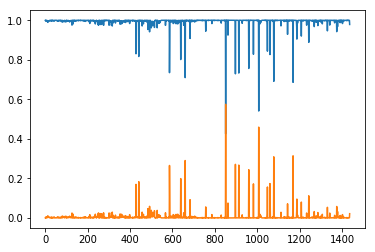

In [78]:
plt.plot(pred)

In [19]:
X_valid.shape

(1437, 29)

SyntaxError: invalid syntax (<ipython-input-103-4f8448a6674e>, line 1)